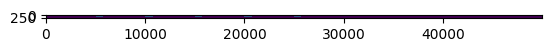

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

#like the first time we did this, making some input sequences...
### case 1, simple Gaussian bump about a third of the way into the line
n_units = 300
n_steps = 500
sd = 15 
case1 = np.zeros((n_units,n_steps))

unit_ids = np.arange(0,n_units,1)
for i in range(0,n_steps):
    case1[:,i] = stats.norm.pdf(unit_ids,150, sd) / np.max(stats.norm.pdf(unit_ids,150, sd)) + stats.norm.pdf(unit_ids,50, sd) / np.max(stats.norm.pdf(unit_ids,50, sd)) * 0.5

case1[:,0:50] = 0 


#plt.imshow(case1,aspect="auto")
#plt.colorbar()


### case 2, lets give it a shift 10 points to the left 

n_units = 300
n_steps = 5000
sd = 15 
case2 = np.zeros((n_units,n_steps))

unit_ids = np.arange(0,n_units,1)
for i in range(0,int(n_steps/2)):
    case2[:,i] = stats.norm.pdf(unit_ids,150, sd) / np.max(stats.norm.pdf(unit_ids,150, sd)) 
    case2[:,i+2500] = stats.norm.pdf(unit_ids,160, sd) / np.max(stats.norm.pdf(unit_ids,150, sd))


### case 3, working with pulsing input

n_units = 300
n_steps = 50000
sd = 15 
case3 = np.ones((n_units,n_steps)) * 0.2

unit_ids = np.arange(0,n_units,1)
for i in np.arange(5000,30000,5000):
    case3[:,i:i+750] = 0.2 + .8 * (stats.norm.pdf(unit_ids,100, sd) / np.max(stats.norm.pdf(unit_ids,150, sd))).reshape(300,1) 

plt.imshow(case3)

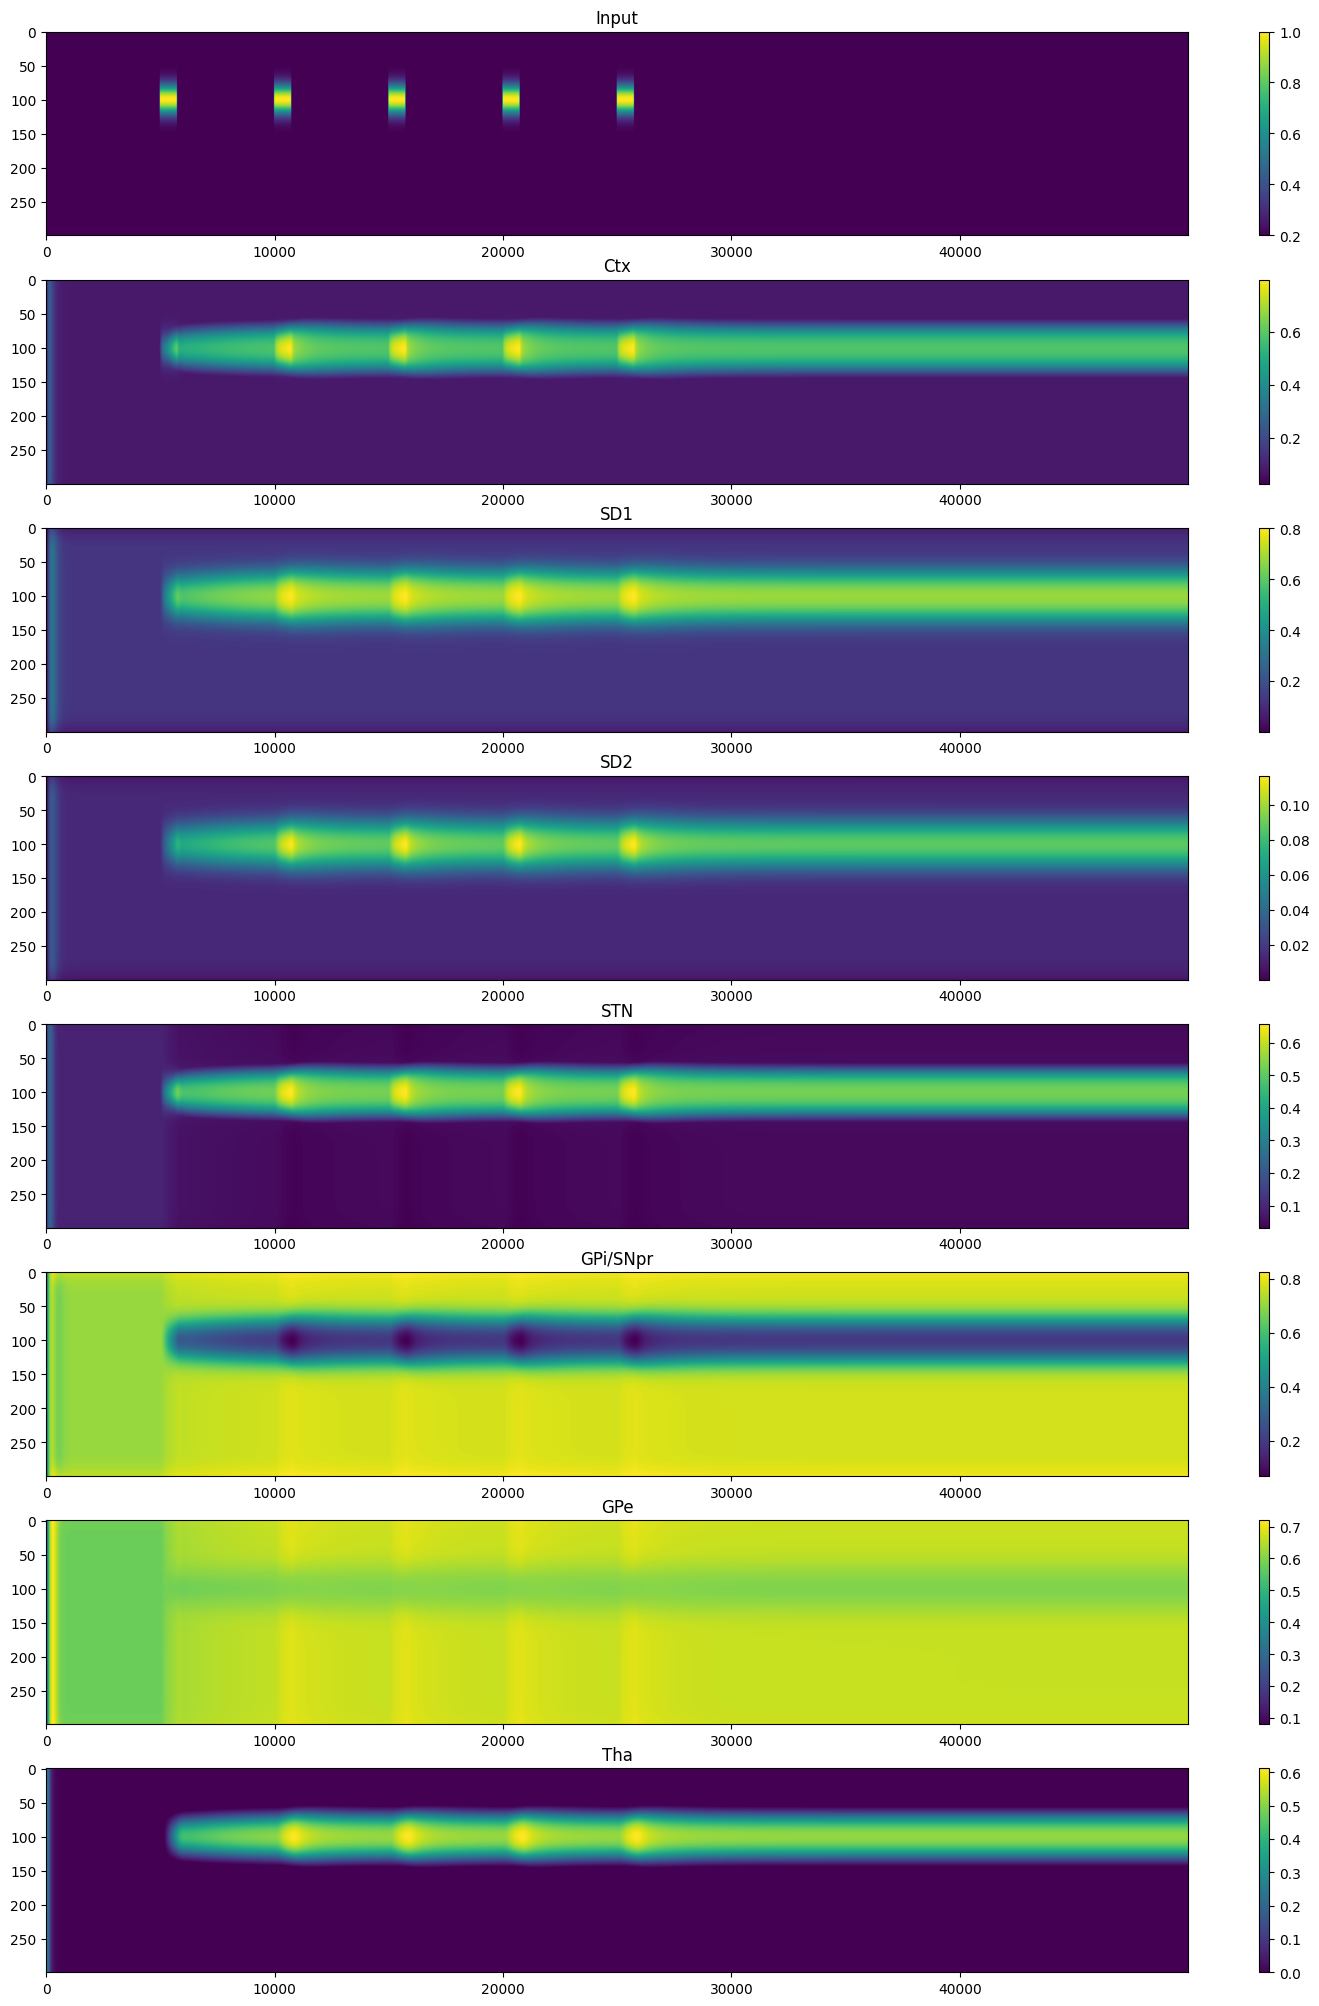

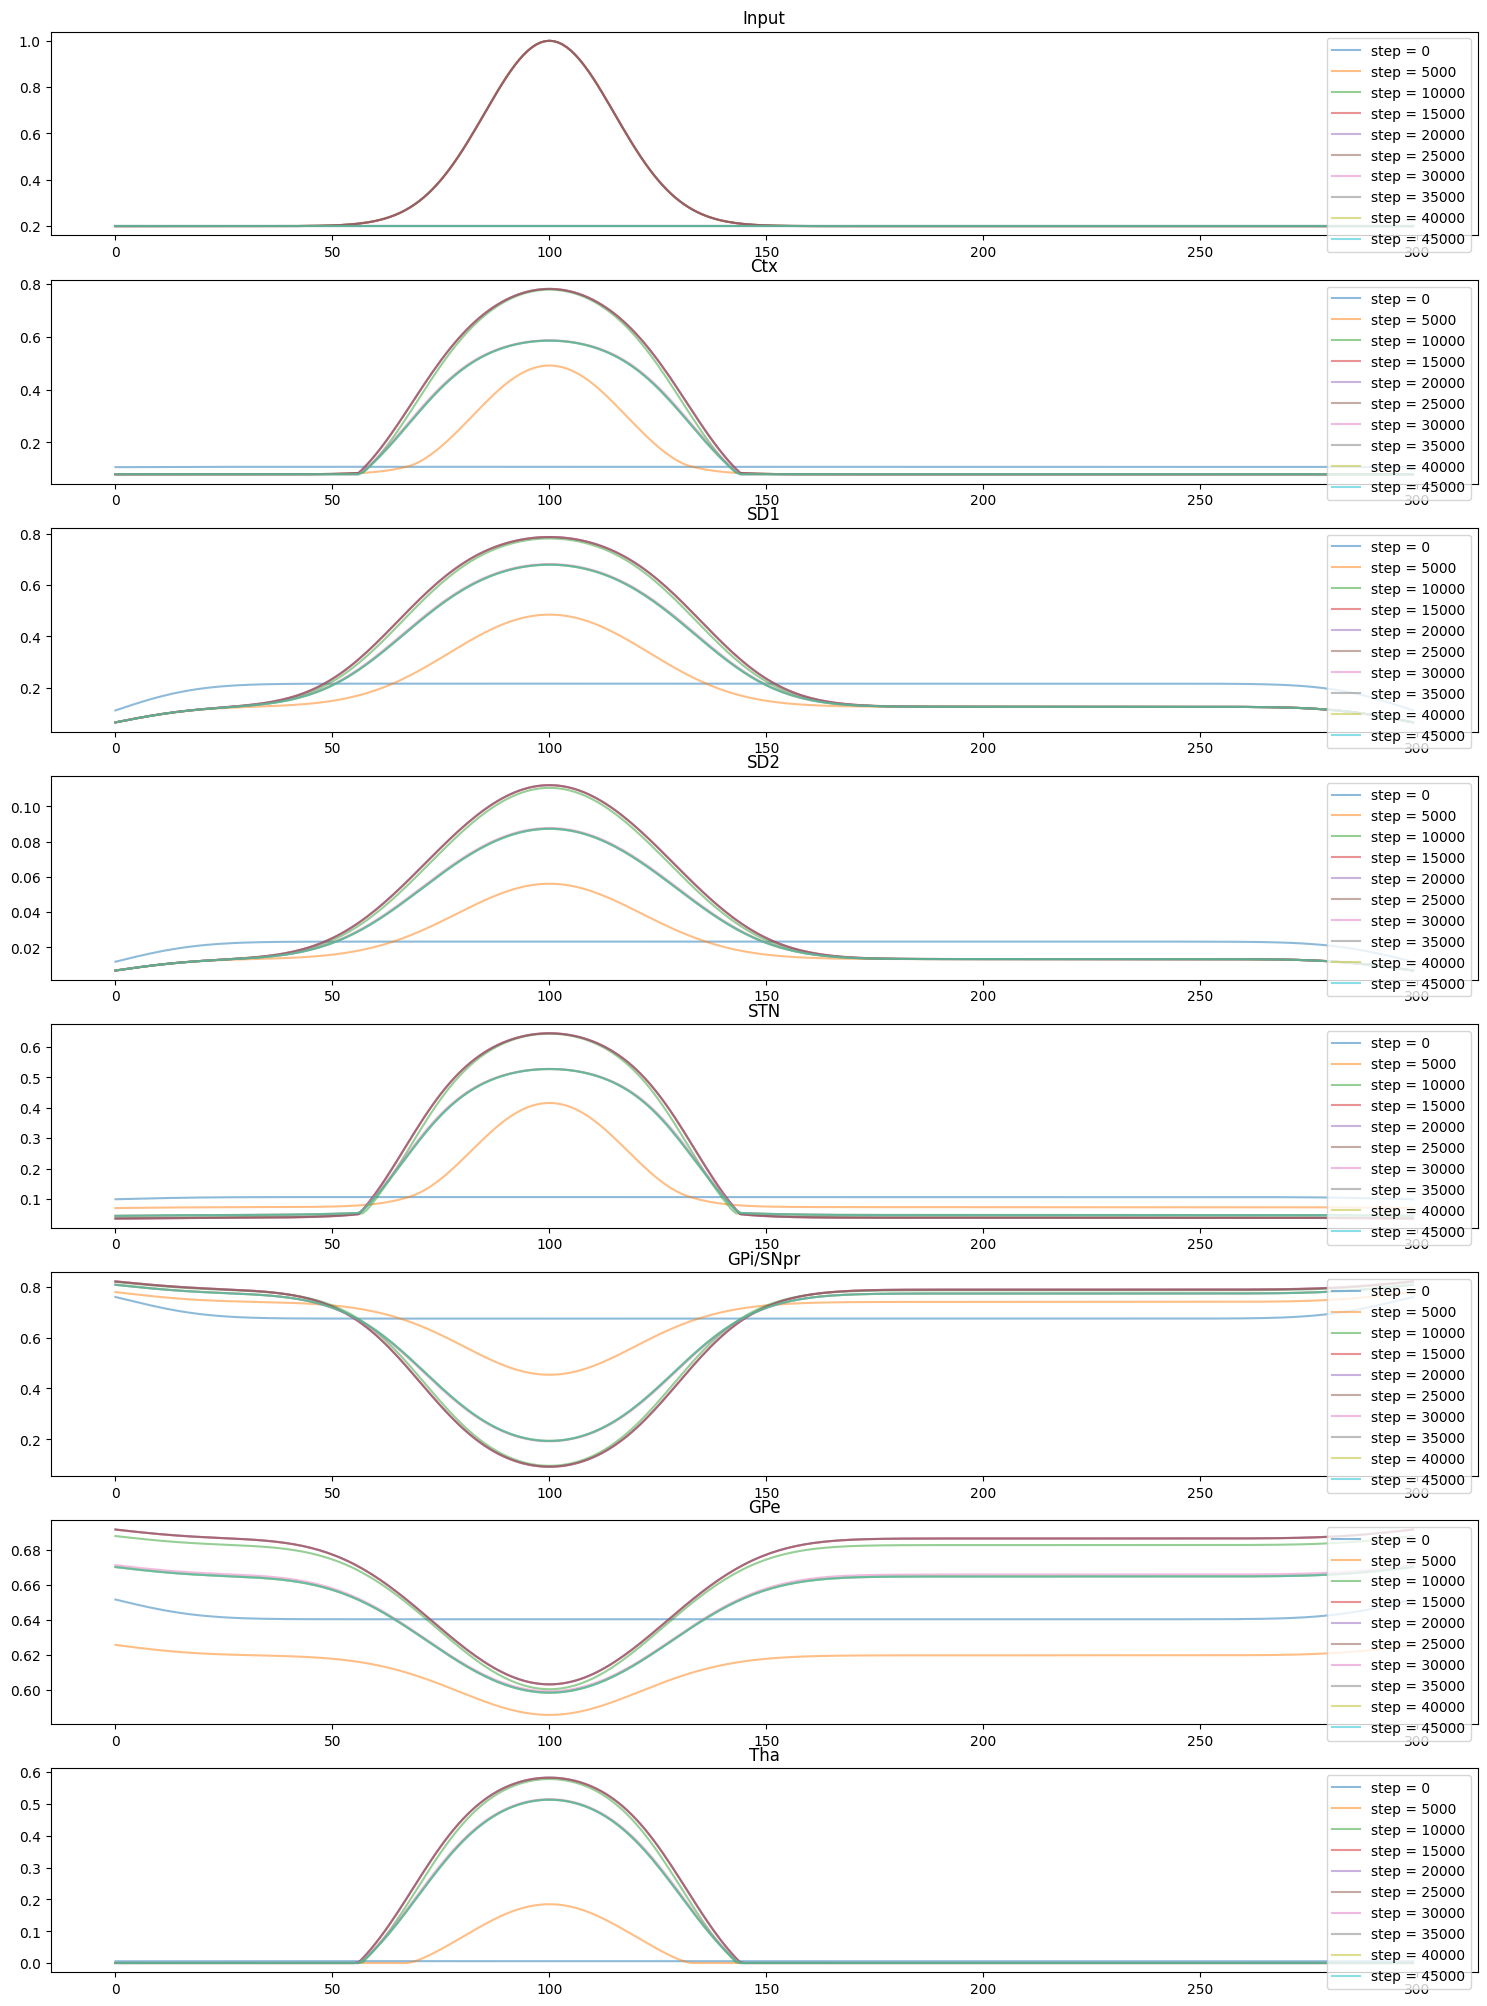

In [32]:
class b_ganglia:
    def __init__(self,n_loops,time_steps,exc_spread1):

        self.n_loops = n_loops
        self.n_steps = time_steps

        #activations for all units
        self.a_sd1 = np.zeros((time_steps, n_loops))
        self.a_sd2 = np.zeros((time_steps, n_loops))
        self.a_stn = np.zeros((time_steps, n_loops))
        self.a_gpi = np.zeros((time_steps, n_loops))
        self.a_gpe = np.zeros((time_steps, n_loops))
        self.a_tha = np.zeros((time_steps, n_loops))
        self.a_ctx = np.zeros((time_steps, n_loops))

        #vector to hold changing dopamine levels
        self.da = np.ones((time_steps))

        #vector to hold the inputs...
        self.a_inp = np.ones((time_steps, n_loops))


        #variable to keep track of what step we are currently on
        self.c = 0

        ####               weights connecting all the layers    #####

        #cortico-striatal connections are topographical, but also overlapping, thus we will use the Guassians we have previously shown work
        #first change from the original version, we will not have "input"-striatum connections, we will have a single cortical layer at the top receiving both "input" and thalamic input

        #initializing the matrices to hold all the weights
        self.w_ctx_sd1 = np.zeros((n_loops,n_loops))
        self.w_ctx_sd2 = np.zeros((n_loops,n_loops))


        #the weights from input to the cortex will just be the identity matrix I think
        self.w_inp_ctx = np.identity(n_loops) * 0.4


        unit_ids = np.arange(0,n_loops,1)        
        for i in range(0,n_loops):
            #inserting the Guassians into the matrix
            #wider-spreading connectivities
            self.w_ctx_sd1[i] = stats.norm.pdf(unit_ids, i, exc_spread1) / np.max(stats.norm.pdf(unit_ids, i, exc_spread1)) * 0.04 #the dividing by the max ensure the weight distribution has a max of 1 before any other changes, just keeps the weights reasonable I think
            self.w_ctx_sd2[i] = stats.norm.pdf(unit_ids, i, exc_spread1) / np.max(stats.norm.pdf(unit_ids, i, exc_spread1)) * 0.04

        #second attempt at this, implementing pure 1-to-1 connectivity
        self.w_ctx_stn = np.identity(n_loops) * 1
        self.w_sd1_gpi = np.identity(n_loops) * -1.5
        self.w_sd2_gpe = np.identity(n_loops) * -1.5
        self.w_gpe_stn = np.identity(n_loops) * -0.5
        self.w_gpe_gpi = np.identity(n_loops) * -0.01
        self.w_gpi_tha = np.identity(n_loops) * -1.2
        self.w_tha_ctx = np.identity(n_loops) * 1.15

        #the STN has dense connectivity to the output nuclei so we can just set these as an array of ones
        self.w_stn_gpi = np.ones((self.n_loops,self.n_loops)) * 0.01
        self.w_stn_gpe = np.ones((self.n_loops,self.n_loops)) * 0.01 

        #previous weight matrices for reference...
        


    #uses euler integration to calculate the activation at each unit in the model of the basal ganglia 
    def step(self, i):

        #likely easier to just define the parameters inside this function...
        dt = 0.0001
        tau = 0.01
        #time constant 
        h= dt/tau

        #define the sensitivies to dopamine and normal response
        sd1_bl = 0.6
        sd1_DA = 0.9
        sd2_bl = 1
        sd2_DA = 8



        #vector containing abstract representation of activity in different cortical areas, receives user determined input, and connections from the thalamus
        self.a_ctx[i+1] = self.a_ctx[i] + h * (self.non_lin(np.matmul(self.input[i], self.w_inp_ctx) + np.matmul(self.a_tha[i], self.w_tha_ctx)) - self.a_ctx[i])
        
        #input to direct pathway of striatum, cortical input modulated by dopamine
        self.a_sd1[i+1] = self.a_sd1[i] + h * (self.non_lin((sd1_bl + sd1_DA * 0.5 * self.da[i]) * np.matmul(self.a_ctx[i], self.w_ctx_sd1)) - self.a_sd1[i])

        #input to sd2 modulated by dopamine
        self.a_sd2[i+1] = self.a_sd2[i] + h * (self.non_lin( (1/(sd2_bl + sd2_DA * self.da[i])) * np.matmul(self.a_ctx[i], self.w_ctx_sd2)) - self.a_sd2[i]) 

        #input to stn from ctx and gpe
        self.a_stn[i+1] = self.a_stn[i] + h * (self.non_lin(np.matmul(self.a_ctx[i], self.w_ctx_stn) + np.matmul(self.a_gpe[i], self.w_gpe_stn) + 0.3) - self.a_stn[i])

        #input to gpe from stn and sd2
        self.a_gpe[i+1] = self.a_gpe[i] + h * (self.non_lin(np.matmul(self.a_sd2[i], self.w_sd2_gpe) + np.matmul(self.a_stn[i], self.w_stn_gpe) + 0.4) - self.a_gpe[i])

        #input to gpi from strd1, stn, and gpe 
        self.a_gpi[i+1] = self.a_gpi[i] + h * (self.non_lin(np.matmul(self.a_sd1[i], self.w_sd1_gpi) + np.matmul(self.a_stn[i], self.w_stn_gpi) + np.matmul(self.a_gpe[i], self.w_gpe_gpi) + 0.8) - self.a_gpi[i])

        #input to thalamus from gpi 
        self.a_tha[i+1] = self.a_tha[i] + h * (self.non_lin(np.matmul(self.a_gpi[i], self.w_gpi_tha) + 0.8) - self.a_tha[i])

        self.c += 1

        return None

    #non-linearity to generate activations
    def non_lin(self,vec):

        #apply non-linearity
        x = np.tanh(vec)
        
        #set any negative values to 0
        for i in range(self.n_loops):
            if x[i] < 0:
                x[i] = 0
        
        return x

    def run(self, steps, input, dopamine):

        self.input = input.T
        self.da = dopamine

        
        for i in range(steps):
            self.step(self.c)

        
    def display(self):

        titles = ('Input','Ctx', 'SD1', 'SD2', "STN", "GPi/SNpr", "GPe", "Tha")
        data = (self.input,  self.a_ctx, self.a_sd1, self.a_sd2, self.a_stn, self.a_gpi, self.a_gpe, self.a_tha)

        fig, ax = plt.subplots(8)
        fig.set_figheight(20)
        fig.set_figwidth(15)
        fig.tight_layout()

        for i in range(8):
            im = ax[i].imshow(data[i][20:].T,aspect='auto')
            ax[i].set_title(titles[i])
            plt.colorbar(im, ax=ax[i])
        
        fig2, ax = plt.subplots(8)
        fig2.set_figheight(20)
        fig2.set_figwidth(15)
        fig2.tight_layout()

        for i in range(8):
            time_steps = np.arange(0,50000,5000)
            for step in time_steps:
                ax[i].plot(data[i][step + 500],alpha=0.5,label= str("step = "+str(step)))
                ax[i].set_title(titles[i])
                ax[i].legend()

        plt.show

        return None


bg2 = b_ganglia(n_loops=300, time_steps=50000, exc_spread1=15)

dopamine = np.ones(50000) * 1

dopamine[30000:35000] = 1

bg2.run(49999,case3,dopamine)
bg2.display()